## Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta as td
import scipy.stats as st

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
# Base.prepare(autoload_with=engine)
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
measure = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measure.date).order_by(measure.date.desc()).first()

('2017-08-23',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date = session.query(measure.date).order_by(measure.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()
one_year_ago = latest_date - td(days=365)
# print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
session.query(measure).filter(measure.date <= '2017-08-23').filter(measure.date >= '2016-08-23')
results = session.query(measure).filter(measure.date <= '2017-08-23').filter(measure.date >= '2016-08-23').all()
data = []
for result in results:
    data.append({
        'date': result.date,
        'precipitation': result.prcp})

# Create a DataFrame from the data
precip = pd.DataFrame(data)

# Sort the dataframe by date
precip = precip.sort_values('date', ascending=False)
precip

,date,precipitation
2229,2017-08-23,0.45
1528,2017-08-23,0.08
1008,2017-08-23,0.00
360,2017-08-23,0.00
1527,2017-08-22,0.00
...,...,...
361,2016-08-23,0.15
1881,2016-08-23,0.70
1192,2016-08-23,0.02
1009,2016-08-23,NaN


In [11]:
# # Use Pandas Plotting with Matplotlib to plot the data 
# precip = pd.DataFrame(precip, columns=['date', 'precipitation'])
# precip.set_index('date', inplace=True)
# precip.plot.bar()
# plt.show()

# Query to get station and its count; list the stations and their counts in descending order.
most_recent_date = session.query(func.max(measure.date)).first()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Assuming you have a DataFrame named 'existing_df' with a 'precipitation' column

# Calculate the statistics using describe()
stats = precip['precipitation'].describe()

# Create a new DataFrame from the statistics dictionary
stats_summary = pd.DataFrame({'precipitation': stats})

# Transpose the DataFrame to have the statistics as columns instead of rows
stats_summary = stats_summary.transpose()

# Rename the index column
stats_summary.index.name 
# pd.melt(stats_summary)
stats_summary

# TIME PERMITTING

,count,mean,std,min,25%,50%,75%,max
precipitation,2021.0,0.177279,0.46119,0.0,0.0,0.02,0.13,6.7


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset

# Calculate the total number of stations in the dataset.
station_count = session.query(station).count()
total_stations = [(station_count,)]
total_stations

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)

# Query to get station and its count; list the stations and their counts in descending order.
hi_action = session.query(measure.station, func.count(measure.station)).\
    group_by(measure.station).\
    order_by(func.count(measure.station).desc()).all()

# Convert the query results to a list 
hi_action_list = [(station, count) for station, count in hi_action]
hi_action_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Get the most active station ID from the previous query
minmax_active = hi_action[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
result = session.query(func.min(measure.tobs), func.max(measure.tobs), func.avg(measure.tobs)).\
    filter(measure.station == minmax_active).all()

# Format the result as a list of tuples
min_max_avg = [result[0]]

print(min_max_avg)

[(54.0, 85.0, 71.66378066378067)]


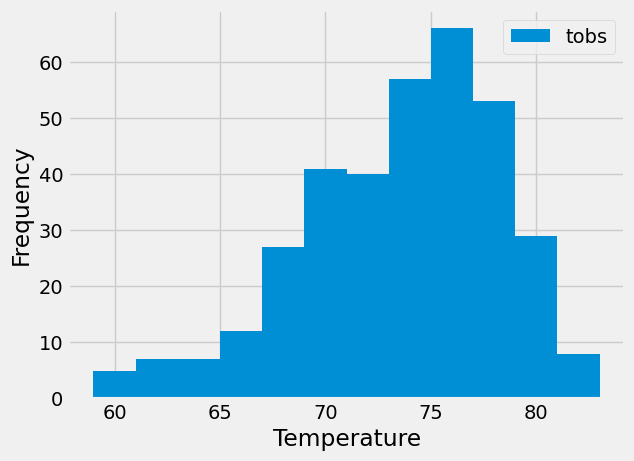

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the last 12 months of temperature observation data for the most active station
temp_data = session.query(measure.tobs).filter(measure.station == minmax_active).\
    filter(measure.date >= one_year_ago).all()

# Extract the temperature values from the query result
temps = [temp[0] for temp in temp_data]

# Plot the histogram
plt.hist(temps, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [17]:
# Close Session
session.close()

# Design Climate App